In [2]:
# 단일 시계열 데이터에 대한 Pytorch 기반 LSTM 예측 구현안
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
aptaprice = pd.read_csv("A:\\시세모니터링\\융합분석\\과거 시가총액 조회/A01011352800003_34.csv", index_col=0)
aptaprice = aptaprice.sort_values(by=["date"])
aptaprice = aptaprice.reset_index()
aptaprice = aptaprice.drop(columns = ["index"])
aptaprice = aptaprice[["date","aptprice"]]
aptaprice = aptaprice.sort_values(by=["date"])
aptaprice

,date,aptprice
0,19970115,25000.0
1,19970215,25000.0
2,19970315,24500.0
3,19970415,24500.0
4,19970515,24500.0
...,...,...
1079,20191115,206500.0
1080,20191122,208500.0
1081,20191129,209500.0
1082,20191206,212500.0


In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

C:\Users\jhpark1\Anaconda3\envs\tc\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jhpark1\Anaconda3\envs\tc\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jhpark1\Anaconda3\envs\tc\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jhpark1\Anaconda3\envs\tc\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jhpark1\Anaconda3\envs\tc\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jhpark1\Anaconda3\envs\tc\lib\site-packages\matplotlib\backends\ba

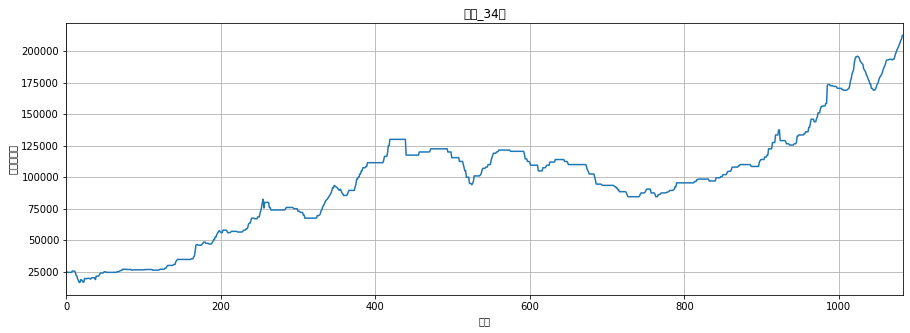

In [53]:
plt.title('은마_34평')
plt.ylabel('시세평균가')
plt.xlabel('연도')
plt.grid(True)
plt.autoscale(axis='x', tight = True)
plt.plot(aptaprice['aptprice'])

In [7]:
all_data = aptaprice["aptprice"].values.astype(float)
all_data

array([ 25000.,  25000.,  24500., ..., 209500., 212500., 212500.])

In [8]:
test_data_size = 52

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [9]:
print(len(train_data))

1032


In [10]:
print(len(test_data))

52


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))
train_data_normalized

array([[-0.90529248],
       [-0.90529248],
       [-0.91086351],
       ...,
       [ 0.94428969],
       [ 0.93314763],
       [ 0.9275766 ]])

In [12]:
# Tensor 형 변환
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized

tensor([-0.9053, -0.9053, -0.9109,  ...,  0.9443,  0.9331,  0.9276])

In [13]:
train_window = 52

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [14]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq

[(tensor([-0.9053, -0.9053, -0.9109, -0.9109, -0.9109, -0.9109, -0.9109, -0.9109,
          -0.8997, -0.8997, -0.8997, -0.8997, -0.9109, -0.9387, -0.9443, -0.9694,
          -0.9833, -1.0000, -1.0000, -0.9749, -0.9777, -0.9861, -0.9972, -0.9972,
          -0.9638, -0.9666, -0.9666, -0.9666, -0.9638, -0.9638, -0.9638, -0.9694,
          -0.9694, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9749, -0.9443,
          -0.9443, -0.9443, -0.9443, -0.9331, -0.9220, -0.9164, -0.9164, -0.9164,
          -0.9164, -0.9081, -0.9053, -0.9053]), tensor([-0.9109])),
 (tensor([-0.9053, -0.9109, -0.9109, -0.9109, -0.9109, -0.9109, -0.9109, -0.8997,
          -0.8997, -0.8997, -0.8997, -0.9109, -0.9387, -0.9443, -0.9694, -0.9833,
          -1.0000, -1.0000, -0.9749, -0.9777, -0.9861, -0.9972, -0.9972, -0.9638,
          -0.9666, -0.9666, -0.9666, -0.9638, -0.9638, -0.9638, -0.9694, -0.9694,
          -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9749, -0.9443, -0.9443,
          -0.9443, -0.9443, -0

In [15]:
len(train_inout_seq)

980

In [17]:
# turple() : 12 numbers of sliced input data, last label of next sliced input data
train_inout_seq[:-978]

[(tensor([-0.9053, -0.9053, -0.9109, -0.9109, -0.9109, -0.9109, -0.9109, -0.9109,
          -0.8997, -0.8997, -0.8997, -0.8997, -0.9109, -0.9387, -0.9443, -0.9694,
          -0.9833, -1.0000, -1.0000, -0.9749, -0.9777, -0.9861, -0.9972, -0.9972,
          -0.9638, -0.9666, -0.9666, -0.9666, -0.9638, -0.9638, -0.9638, -0.9694,
          -0.9694, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9749, -0.9443,
          -0.9443, -0.9443, -0.9443, -0.9331, -0.9220, -0.9164, -0.9164, -0.9164,
          -0.9164, -0.9081, -0.9053, -0.9053]), tensor([-0.9109])),
 (tensor([-0.9053, -0.9109, -0.9109, -0.9109, -0.9109, -0.9109, -0.9109, -0.8997,
          -0.8997, -0.8997, -0.8997, -0.9109, -0.9387, -0.9443, -0.9694, -0.9833,
          -1.0000, -1.0000, -0.9749, -0.9777, -0.9861, -0.9972, -0.9972, -0.9638,
          -0.9666, -0.9666, -0.9666, -0.9638, -0.9638, -0.9638, -0.9694, -0.9694,
          -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9749, -0.9443, -0.9443,
          -0.9443, -0.9443, -0

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [19]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [21]:
# training the Model

epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i%10 == 1:
        print(f'epoch : {i:3} loss:{single_loss.item():10.8f}')
        
print(f'epoch : {i:3} loss:{single_loss.item():10.10f}')

epoch :   1 loss:0.00053915
epoch :  11 loss:0.00000183
epoch :  21 loss:0.00000501
epoch :  31 loss:0.00006131
epoch :  41 loss:0.00000000
epoch :  51 loss:0.00004979
epoch :  61 loss:0.00006459
epoch :  71 loss:0.00004141
epoch :  81 loss:0.00003756
epoch :  91 loss:0.00264783
epoch : 101 loss:0.00358625
epoch : 111 loss:0.00059036
epoch : 121 loss:0.00000436
epoch : 131 loss:0.00024680
epoch : 141 loss:0.00016358
epoch : 149 loss:0.0001314520


In [22]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.5598886013031006, 0.5598886013031006, 0.5598886013031006, 0.582172691822052, 0.582172691822052, 0.7437325716018677, 0.7493036389350891, 0.7493036389350891, 0.7493036389350891, 0.738161563873291, 0.738161563873291, 0.738161563873291, 0.738161563873291, 0.7325905561447144, 0.7325905561447144, 0.7325905561447144, 0.7325905561447144, 0.7270194888114929, 0.7158774137496948, 0.7158774137496948, 0.7158774137496948, 0.7158774137496948, 0.7158774137496948, 0.7158774137496948, 0.7047353982925415, 0.7047353982925415, 0.6991643309593201, 0.6991643309593201, 0.6991643309593201, 0.6991643309593201, 0.6991643309593201, 0.7047353982925415, 0.7103064060211182, 0.7158774137496948, 0.7437325716018677, 0.7827298045158386, 0.8050139546394348, 0.844011127948761, 0.8607242107391357, 0.8830083608627319, 0.9442896842956543, 0.9777158498764038, 0.9944289922714233, 0.9944289922714233, 1.0, 0.9944289922714233, 0.9888579249382019, 0.9665738344192505, 0.9498607516288757, 0.9442896842956543, 0.9331476092338562, 0

In [23]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                       torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [105]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
actual_predictions

array([[190629.02086973],
       [191418.34208369],
       [193409.90301967],
       [194829.22613621],
       [196995.84466219],
       [198424.90389943],
       [199899.36983585],
       [200317.59506464],
       [200655.02119064],
       [199948.83146882],
       [199360.71628332],
       [198064.54974413]])

In [192]:
date = pd.date_range("2019-12-20", "2020-3-6", freq="W-FRI")
date = date.astype(str).str.split('-').str[0] + date.astype(str).str.split('-').str[1] + date.astype(str).str.split('-').str[2]  

In [193]:
x = np.arange(len(aptaprice['aptprice']), len(aptaprice['aptprice'])+12, 1)

In [201]:
actual_predictions_s = pd.DataFrame({'date' : date.values.astype(int), 'aptprice_34' : actual_predictions.reshape(-1).astype(int)}, index = x )
actual_predictions_s

,date,aptprice_34
1084,20191220,190629
1085,20191227,191418
1086,20200103,193409
1087,20200110,194829
1088,20200117,196995
1089,20200124,198424
1090,20200131,199899
1091,20200207,200317
1092,20200214,200655
1093,20200221,199948


In [ ]:
# actual_predictions_s.to_csv('Eunma_34sq_w52.csv')

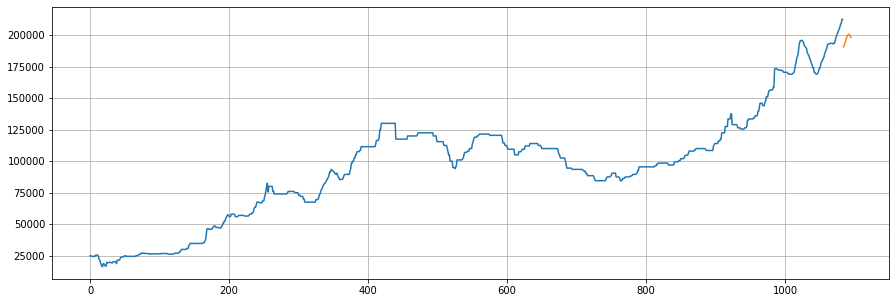

In [194]:
plt.grid(True)
# plt.autoscale(axis = 'x', tight = True)
plt.plot(aptaprice.index,aptaprice['aptprice'])
plt.plot(actual_predictions_s.index, actual_predictions_s["aptprice"])